In [98]:
import numpy as np
from scipy.linalg import eigh
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import robust_laplacian
from Mesh import Mesh
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import sparse

In [6]:
m = Mesh('bunny.obj')

centroid = m.verts.mean(0)
std_max = m.verts.std(0).max()

verts_new = (m.verts - centroid)/std_max

m = Mesh(verts = verts_new, connectivity = m.connectivity)

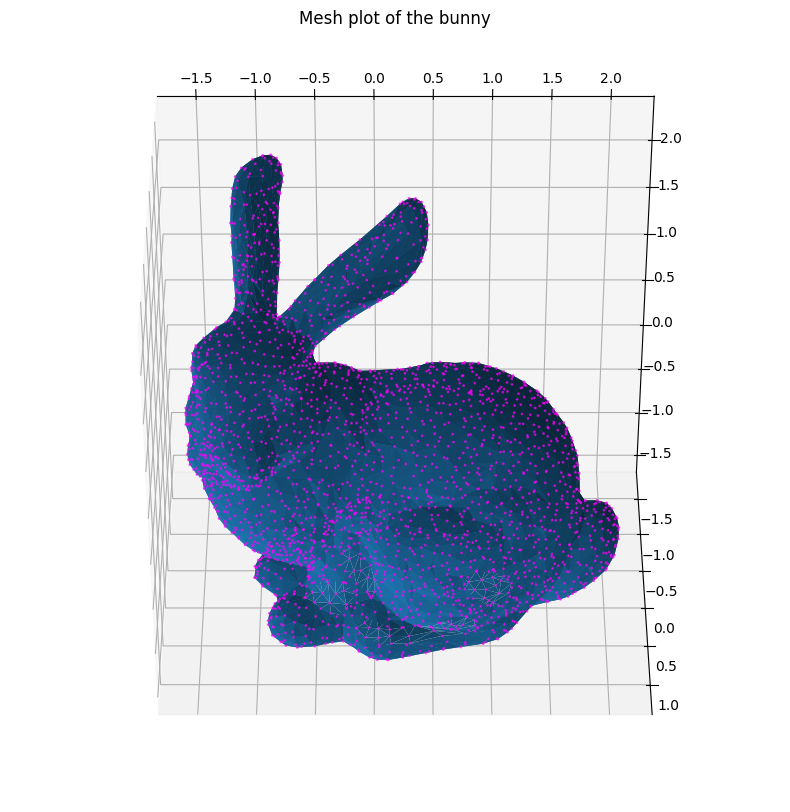

In [70]:
ax =  plt.figure(figsize=(10,10)).add_subplot(projection='3d')
surf = ax.plot_trisurf(m.verts[:,0], m.verts[:,1], m.verts[:,2], triangles = m.connectivity)
ax.scatter(verts_new[:, 0], verts_new[:, 1], verts_new[:, 2], c='fuchsia', s=1, alpha=0.6)
ax.set_title('Mesh plot of the bunny')
ax.view_init(elev=130, azim=-90)
plt.show()

In [82]:
# downsampled points, for the sake of the argument just take each third point
points = verts_new[::3]

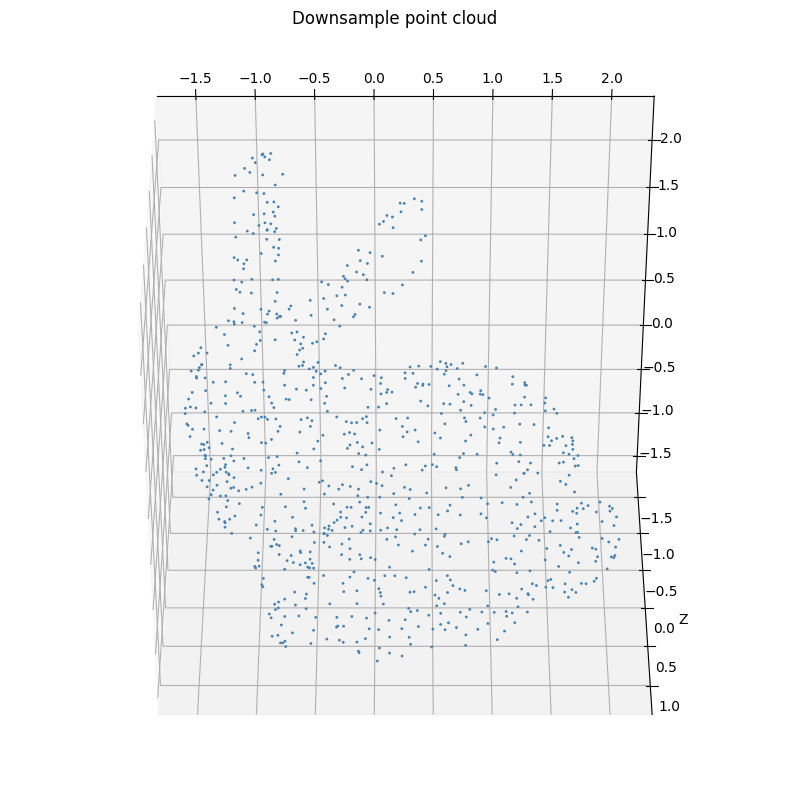

In [84]:
# Create a 3D figure
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

# Scatter plot of vertices
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='steelblue', s=1, alpha=1)

ax.set_zlabel('Z')
ax.set_title('Downsample point cloud')
ax.view_init(elev=130, azim=-90)

plt.show()

In [94]:
# Build point cloud Laplacian
L_full, M_full = robust_laplacian.point_cloud_laplacian(verts_new)
L_smpl, M_smpl = robust_laplacian.point_cloud_laplacian(points)

print(f"* The full point cloud has L of size: {L_full.shape} *")
print(f"* The downsampled cloud has L of size: {L_smpl.shape} *")

* The full point cloud has L of size: (2503, 2503) *
* The downsampled cloud has L of size: (835, 835) *


In [95]:
# Compute exact eigenvalues on the reduced point cloud
n_eig = 10
eigvals, eigvecs = sla.eigsh(L_smpl, n_eig, M_smpl, sigma=1e-8)
print(f"* The exact eigenfunctions on downsampled mesh are of size: {eigvecs.shape} *")

* The exact eigenfunctions on downsampled mesh are of size: (835, 10) *


In [105]:
X_full = verts_new
X_smpl = points

import torch
import torch.nn as nn
import torch.optim as optim
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
import numpy as np

# ============================================================
# Inputs assumed to be available:
# L_full: scipy.sparse.csc_matrix or csr_matrix (N,N)
# M_full: scipy.sparse.csc_matrix or csr_matrix (N,N)
# X_full: (N,d) numpy array
# X_smpl: (n,d) numpy array
# eigvals, eigvecs: coarse eigenpairs from (L_smpl, M_smpl)
# ============================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Sin(nn.Module):
    """Sine activation for SIREN-style networks"""
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

# ============================================================
# Convert scipy sparse -> torch sparse
# ============================================================

def scipy_to_torch_sparse(A):
    if not sparse.isspmatrix_coo(A):
        A = A.tocoo()
    indices = torch.tensor(np.vstack((A.row, A.col)), dtype=torch.long)
    values = torch.tensor(A.data, dtype=torch.float32)
    return torch.sparse_coo_tensor(indices, values, A.shape).to(device)

L_torch = scipy_to_torch_sparse(L_full)
M_torch = scipy_to_torch_sparse(M_full)

# ============================================================
# Convert arrays to torch
# ============================================================

X_full_torch = torch.tensor(X_full, dtype=torch.float32, device=device)
X_smpl_torch = torch.tensor(X_smpl, dtype=torch.float32, device=device)
eigvecs_torch = torch.tensor(eigvecs, dtype=torch.float32, device=device)
eigvals_torch = torch.tensor(eigvals, dtype=torch.float32, device=device)

N, d = X_full.shape
k = eigvecs.shape[1]  # number of eigenmodes

# ============================================================
# Build coarse -> fine prolongation via nearest-neighbor
# ============================================================

nn_interp = NearestNeighbors(n_neighbors=1).fit(X_smpl)
dists, idx = nn_interp.kneighbors(X_full)
P_idx = idx[:, 0]
U0_np = eigvecs[P_idx, :]  # (N, k)
U0 = torch.tensor(U0_np, dtype=torch.float32, device=device)

# ============================================================
# Define multi-output MLP network
# ============================================================

class EigenNet(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super().__init__()
        self.input = nn.Linear(d_in, d_hidden)
        self.hidden = nn.ModuleList([nn.Linear(d_hidden, d_hidden) for _ in range(3)])
        self.output = nn.Linear(d_hidden, d_out)
        self.act = Sin()

    def forward(self, x):
        x = self.act(self.input(x))
        for layer in self.hidden:
            x = self.act(layer(x))
        x = self.output(x)
        return x

net = EigenNet(d_in=d, d_hidden=128, d_out=k).to(device)

# ============================================================
# Pretrain: fit coarse-upsampled eigenvectors
# ============================================================

opt = optim.Adam(net.parameters(), lr=1e-3)
for epoch in range(2000):
    opt.zero_grad()
    pred = net(X_full_torch)
    loss_fit = torch.mean((pred - U0) ** 2)
    loss_fit.backward()
    opt.step()
    if epoch % 500 == 0:
        print(f"Pretrain epoch {epoch}, loss_fit={loss_fit.item():.4e}")

# ============================================================
# Helper functions
# ============================================================

def matvec(A_sparse, v):
    return torch.sparse.mm(A_sparse, v)

def mass_inner(u, v):
    return torch.sum(u * matvec(M_torch, v), dim=0, keepdim=True)

def normalize(u):
    # M-orthonormalize + Gram-Schmidt
    with torch.no_grad():
        for i in range(u.shape[1]):
            ui = u[:, i:i+1]
            ui /= torch.sqrt(mass_inner(ui, ui) + 1e-12)
            u[:, i:i+1] = ui
        # Gram-Schmidt
        for i in range(1, u.shape[1]):
            for j in range(i):
                coeff = mass_inner(u[:, j:j+1], u[:, i:i+1])
                u[:, i:i+1] -= coeff * u[:, j:j+1]
    return u

# ============================================================
# PINN training: residual + orthogonality + coarse value loss
# ============================================================

optimizer = optim.Adam(net.parameters(), lr=1e-4)

for epoch in range(5000):
    optimizer.zero_grad()
    U_pred = net(X_full_torch)  # (N, k)
    U_pred = normalize(U_pred)
    
    LU = matvec(L_torch, U_pred)
    MU = matvec(M_torch, U_pred)
    
    # Rayleigh quotient
    num = torch.sum(U_pred * LU, dim=0)
    den = torch.sum(U_pred * MU, dim=0) + 1e-12
    lambdas = num / den

    # Residual loss
    res = LU - MU * lambdas
    loss_res = torch.mean(torch.sum(res**2, dim=0) / (torch.sum(MU**2, dim=0) + 1e-12))

    # Orthogonality loss
    MtU = matvec(M_torch, U_pred)
    Gram = torch.matmul(U_pred.T, MtU)
    I = torch.eye(k, device=device)
    loss_orth = torch.mean((Gram - I)**2)

    # Coarse eigenvalue regularization (optional)
    loss_val = torch.mean((lambdas - eigvals_torch[:k])**2)

    # Total loss
    loss = loss_res + 0.1 * loss_orth + 0.01 * loss_val
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, loss={loss.item():.3e}, res={loss_res.item():.3e}")

# ============================================================
# Final outputs
# ============================================================

U_final = net(X_full_torch).detach().cpu().numpy()  # (N, k)
lambda_final = lambdas.detach().cpu().numpy()
print("Approx eigenvalues:", lambda_final)


Pretrain epoch 0, loss_fit=3.8433e-02
Pretrain epoch 500, loss_fit=5.2942e-04
Pretrain epoch 1000, loss_fit=3.5636e-04
Pretrain epoch 1500, loss_fit=4.3000e-04
Epoch 0, loss=1.233e+01, res=1.233e+01
Epoch 500, loss=1.540e+00, res=1.521e+00
Epoch 1000, loss=1.243e+00, res=1.224e+00
Epoch 1500, loss=8.455e+01, res=8.445e+01
Epoch 2000, loss=4.398e+00, res=4.381e+00
Epoch 2500, loss=1.858e+02, res=1.855e+02
Epoch 3000, loss=2.435e+01, res=2.432e+01
Epoch 3500, loss=1.345e+01, res=1.343e+01
Epoch 4000, loss=1.950e+03, res=1.940e+03
Epoch 4500, loss=1.064e+02, res=1.063e+02
Approx eigenvalues: [5.9934804e-04 1.1610223e+01 3.1819691e+01 3.1335510e+01 3.3058212e+01
 3.2684498e+01 3.2808769e+01 3.2923992e+01 3.2125259e+01 3.1582760e+01]


In [103]:
eigvals_full, eigvecs_full = sla.eigsh(L_full, n_eig, M_full, sigma=1e-8)

In [104]:
eigvals_full

array([3.14290890e-16, 2.87932418e-01, 7.21707187e-01, 8.41500753e-01,
       1.03935277e+00, 1.20241748e+00, 1.76211690e+00, 2.59945315e+00,
       2.92344025e+00, 2.97270048e+00])

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
import numpy as np

# ============================================================
# Inputs assumed to be available:
# L_full: scipy.sparse.csc_matrix or csr_matrix (N,N)
# M_full: scipy.sparse.csc_matrix or csr_matrix (N,N)
# X_full: (N,d) numpy array
# X_smpl: (n,d) numpy array
# eigvals, eigvecs: coarse eigenpairs from (L_smpl, M_smpl)
# ============================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ============================================================
# Convert scipy sparse -> torch sparse
# ============================================================

def scipy_to_torch_sparse(A):
    if not sparse.isspmatrix_coo(A):
        A = A.tocoo()
    indices = torch.tensor(np.vstack((A.row, A.col)), dtype=torch.long)
    values = torch.tensor(A.data, dtype=torch.float32)
    return torch.sparse_coo_tensor(indices, values, A.shape).to(device)

L_torch = scipy_to_torch_sparse(L_full)
M_torch = scipy_to_torch_sparse(M_full)

# ============================================================
# Convert arrays to torch
# ============================================================

X_full_torch = torch.tensor(X_full, dtype=torch.float32, device=device)
X_smpl_torch = torch.tensor(X_smpl, dtype=torch.float32, device=device)
eigvecs_torch = torch.tensor(eigvecs, dtype=torch.float32, device=device)
eigvals_torch = torch.tensor(eigvals, dtype=torch.float32, device=device)

N, d = X_full.shape
k = eigvecs.shape[1]  # number of eigenmodes

# ============================================================
# Build coarse -> fine prolongation via nearest-neighbor
# ============================================================

nn_interp = NearestNeighbors(n_neighbors=1).fit(X_smpl)
dists, idx = nn_interp.kneighbors(X_full)
P_idx = idx[:, 0]
U0_np = eigvecs[P_idx, :]  # (N, k)
U0 = torch.tensor(U0_np, dtype=torch.float32, device=device)

# ============================================================
# Sine activation (SIREN)
# ============================================================

class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class EigenNet(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.input = nn.Linear(d_in, d_hidden)
        self.hidden = nn.ModuleList([nn.Linear(d_hidden, d_hidden) for _ in range(3)])
        self.output = nn.Linear(d_hidden, d_out)
        self.act = Sin()
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            # First layer
            self.input.weight.uniform_(-1 / self.input.in_features, 1 / self.input.in_features)
            # Hidden layers
            for layer in self.hidden:
                layer.weight.uniform_(-np.sqrt(6 / layer.in_features) / self.omega_0,
                                      np.sqrt(6 / layer.in_features) / self.omega_0)
    
    def forward(self, x):
        x = self.act(self.input(self.omega_0 * x))  # scale inputs
        for layer in self.hidden:
            x = self.act(layer(x))
        x = self.output(x)
        return x

net = EigenNet(d_in=d, d_hidden=128, d_out=k).to(device)

# ============================================================
# Helper functions
# ============================================================

def matvec(A_sparse, v):
    return torch.sparse.mm(A_sparse, v)

def mass_inner(u, v):
    return torch.sum(u * matvec(M_torch, v), dim=0, keepdim=True)

def normalize(u):
    # M-orthonormalize + Gram-Schmidt
    with torch.no_grad():
        for i in range(u.shape[1]):
            ui = u[:, i:i+1]
            ui /= torch.sqrt(mass_inner(ui, ui) + 1e-12)
            u[:, i:i+1] = ui
        # Gram-Schmidt
        for i in range(1, u.shape[1]):
            for j in range(i):
                coeff = mass_inner(u[:, j:j+1], u[:, i:i+1])
                u[:, i:i+1] -= coeff * u[:, j:j+1]
    return u

# ============================================================
# Pretrain: fit coarse-upsampled eigenvectors
# ============================================================

opt = optim.Adam(net.parameters(), lr=1e-3)
for epoch in range(2000):
    opt.zero_grad()
    pred = net(X_full_torch)
    loss_fit = torch.mean((pred - U0) ** 2)
    loss_fit.backward()
    opt.step()
    if epoch % 500 == 0:
        print(f"Pretrain epoch {epoch}, loss_fit={loss_fit.item():.4e}")

# ============================================================
# PINN training: properly mass-normalized
# ============================================================

optimizer = optim.Adam(net.parameters(), lr=1e-5)  # smaller LR
max_grad_norm = 1.0  # gradient clipping

for epoch in range(5000):
    optimizer.zero_grad()
    U_pred = net(X_full_torch)  # (N, k)
    
    # Mass-orthonormalize columns before residual computation
    U_pred = normalize(U_pred)
    
    # Compute matvecs
    LU = matvec(L_torch, U_pred)
    MU = matvec(M_torch, U_pred)
    
    # Rayleigh quotient
    num = torch.sum(U_pred * LU, dim=0)
    den = torch.sum(U_pred * MU, dim=0) + 1e-12
    lambdas = num / den

    # Residual (normalized by operator magnitude)
    res = LU - MU * lambdas
    loss_res = torch.mean(torch.norm(res, dim=0) / (torch.norm(LU, dim=0) + 1e-12))

    # Orthogonality loss (should be ~0 after normalize(), but keep for stability)
    MtU = matvec(M_torch, U_pred)
    Gram = torch.matmul(U_pred.T, MtU)
    I = torch.eye(k, device=device)
    loss_orth = torch.mean((Gram - I)**2)

    # Optional: coarse eigenvalue regularization
    loss_val = torch.mean((lambdas - eigvals_torch[:k])**2)

    # Total loss
    loss = loss_res + 0.1 * loss_orth + 0.01 * loss_val
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_grad_norm)
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, loss={loss.item():.3e}, res={loss_res.item():.3e}, λ[0]={lambdas[0].item():.4f}")

# ============================================================
# Final outputs
# ============================================================

# Final mass-normalized eigenvectors
U_final = normalize(net(X_full_torch)).detach().cpu().numpy()  # (N, k)
LU_final = matvec(L_torch, torch.tensor(U_final, dtype=torch.float32, device=device))
MU_final = matvec(M_torch, torch.tensor(U_final, dtype=torch.float32, device=device))
num_final = torch.sum(torch.tensor(U_final, device=device) * LU_final, dim=0)
den_final = torch.sum(torch.tensor(U_final, device=device) * MU_final, dim=0) + 1e-12
lambda_final = (num_final / den_final).detach().cpu().numpy()

print("Approx eigenvalues (correct scale):", lambda_final)

Pretrain epoch 0, loss_fit=3.8285e-02
Pretrain epoch 500, loss_fit=3.5784e-04
Pretrain epoch 1000, loss_fit=2.1003e-04
Pretrain epoch 1500, loss_fit=1.6370e-04
Epoch 0, loss=1.001e+00, res=9.860e-01, λ[0]=0.0001
Epoch 500, loss=9.306e-01, res=9.063e-01, λ[0]=1.2122
Epoch 1000, loss=9.014e-01, res=8.656e-01, λ[0]=2.2118
Epoch 1500, loss=9.310e-01, res=8.845e-01, λ[0]=2.2066
Epoch 2000, loss=9.216e-01, res=8.762e-01, λ[0]=1.5379
Epoch 2500, loss=9.672e-01, res=9.006e-01, λ[0]=1.9700
Epoch 3000, loss=9.319e-01, res=8.895e-01, λ[0]=1.7662
Epoch 3500, loss=9.576e-01, res=9.082e-01, λ[0]=1.8480
Epoch 4000, loss=1.030e+00, res=9.645e-01, λ[0]=3.7525
Epoch 4500, loss=1.039e+00, res=9.813e-01, λ[0]=3.8345
Approx eigenvalues (correct scale): [6.3219404 3.020245  2.8932369 1.7640247 4.409258  3.172291  5.1372232
 5.020006  4.031112  6.7260137]


In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ============================================================
# Inputs assumed to be available
# ============================================================

# L_full, M_full: scipy.sparse matrices
# X_full, X_smpl: numpy arrays
# eigvals, eigvecs: coarse eigenpairs

# Convert sparse matrices to torch sparse
def scipy_to_torch_sparse(A):
    if not sparse.isspmatrix_coo(A):
        A = A.tocoo()
    indices = torch.tensor(np.vstack((A.row, A.col)), dtype=torch.long)
    values = torch.tensor(A.data, dtype=torch.float32)
    return torch.sparse_coo_tensor(indices, values, A.shape).to(device)

L_torch = scipy_to_torch_sparse(L_full)
M_torch = scipy_to_torch_sparse(M_full)

X_full_torch = torch.tensor(X_full, dtype=torch.float32, device=device)
X_smpl_torch = torch.tensor(X_smpl, dtype=torch.float32, device=device)
eigvecs_torch = torch.tensor(eigvecs, dtype=torch.float32, device=device)
eigvals_torch = torch.tensor(eigvals, dtype=torch.float32, device=device)

N, d = X_full.shape
k = eigvecs.shape[1]  # number of eigenvectors to compute

# ============================================================
# Coarse → fine prolongation
# ============================================================

nn_interp = NearestNeighbors(n_neighbors=1).fit(X_smpl)
dists, idx = nn_interp.kneighbors(X_full)
U0_np = eigvecs[idx[:, 0], :]
U0 = torch.tensor(U0_np, dtype=torch.float32, device=device)

# ============================================================
# SIREN network
# ============================================================

class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class EigenNet(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.input = nn.Linear(d_in, d_hidden)
        self.hidden = nn.ModuleList([nn.Linear(d_hidden, d_hidden) for _ in range(3)])
        self.output = nn.Linear(d_hidden, d_out)
        self.act = Sin()
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            self.input.weight.uniform_(-1/self.input.in_features, 1/self.input.in_features)
            for layer in self.hidden:
                layer.weight.uniform_(-np.sqrt(6/layer.in_features)/self.omega_0,
                                      np.sqrt(6/layer.in_features)/self.omega_0)

    def forward(self, x):
        x = self.act(self.input(self.omega_0 * x))
        for layer in self.hidden:
            x = self.act(layer(x))
        x = self.output(x)
        return x

# ============================================================
# Helper functions
# ============================================================

def matvec(A_sparse, v):
    return torch.sparse.mm(A_sparse, v)

def mass_inner(u, v):
    return torch.sum(u * matvec(M_torch, v), dim=0, keepdim=True)

def normalize(u, prev_U=None):
    """M-orthonormalize columns; optionally orthogonalize against prev_U"""
    with torch.no_grad():
        if prev_U is not None:
            for i in range(u.shape[1]):
                for j in range(prev_U.shape[1]):
                    coeff = mass_inner(prev_U[:, j:j+1], u[:, i:i+1])
                    u[:, i:i+1] -= coeff * prev_U[:, j:j+1]

        for i in range(u.shape[1]):
            ui = u[:, i:i+1]
            ui /= torch.sqrt(mass_inner(ui, ui) + 1e-12)
            u[:, i:i+1] = ui
    return u

# ============================================================
# Sequential eigenvector training
# ============================================================

U_all = []

for mode in range(k):
    print(f"\nTraining eigenvector {mode+1}/{k}")

    # One-output network
    net = EigenNet(d_in=d, d_hidden=128, d_out=1).to(device)

    # Pretrain on coarse eigenvector
    U0_mode = U0[:, mode:mode+1]
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    for epoch in range(1000):
        optimizer.zero_grad()
        pred = net(X_full_torch)
        loss_fit = torch.mean((pred - U0_mode)**2)
        loss_fit.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Pretrain epoch {epoch}, loss_fit={loss_fit.item():.4e}")

    # PINN training
    optimizer = optim.Adam(net.parameters(), lr=1e-5)
    max_grad_norm = 1.0

    prev_U = torch.cat(U_all, dim=1) if len(U_all) > 0 else None

    for epoch in range(3000):
        optimizer.zero_grad()
        U_pred = net(X_full_torch)
        U_pred = normalize(U_pred, prev_U)

        LU = matvec(L_torch, U_pred)
        MU = matvec(M_torch, U_pred)

        num = torch.sum(U_pred * LU, dim=0)
        den = torch.sum(U_pred * MU, dim=0) + 1e-12
        lambda_pred = num / den

        res = LU - MU * lambda_pred
        loss_res = torch.mean(torch.norm(res, dim=0) / (torch.norm(LU, dim=0) + 1e-12))
        loss = loss_res
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_grad_norm)
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, loss={loss.item():.3e}, λ={lambda_pred.item():.4f}")

    # Store trained eigenvector
    U_all.append(normalize(net(X_full_torch), prev_U).detach())

# ============================================================
# Final eigenvectors & eigenvalues
# ============================================================

U_final = torch.cat(U_all, dim=1)
LU_final = matvec(L_torch, U_final)
MU_final = matvec(M_torch, U_final)
num_final = torch.sum(U_final * LU_final, dim=0)
den_final = torch.sum(U_final * MU_final, dim=0) + 1e-12
lambda_final = (num_final / den_final).detach().cpu().numpy()

print("\nApprox eigenvalues (smallest to largest):", lambda_final)



Training eigenvector 1/10
Pretrain epoch 0, loss_fit=4.4186e-02
Pretrain epoch 500, loss_fit=2.5174e-11
Epoch 0, loss=1.000e+00, λ=0.0000
Epoch 500, loss=4.318e-01, λ=72.3411
Epoch 1000, loss=3.229e-01, λ=78.9258
Epoch 1500, loss=2.923e-01, λ=79.8314
Epoch 2000, loss=2.720e-01, λ=80.3617
Epoch 2500, loss=2.573e-01, λ=80.9955

Training eigenvector 2/10
Pretrain epoch 0, loss_fit=3.9483e-02
Pretrain epoch 500, loss_fit=7.0674e-05
Epoch 0, loss=9.882e-01, λ=0.3647
Epoch 500, loss=7.228e-01, λ=17.9181
Epoch 1000, loss=3.633e-01, λ=43.4664
Epoch 1500, loss=3.209e-01, λ=47.1600
Epoch 2000, loss=2.980e-01, λ=48.2763
Epoch 2500, loss=2.799e-01, λ=48.8429

Training eigenvector 3/10
Pretrain epoch 0, loss_fit=4.1474e-02
Pretrain epoch 500, loss_fit=1.7995e-04
Epoch 0, loss=9.907e-01, λ=1.3827
Epoch 500, loss=4.727e-01, λ=58.2206
Epoch 1000, loss=3.213e-01, λ=72.3268
Epoch 1500, loss=2.931e-01, λ=74.5238
Epoch 2000, loss=2.811e-01, λ=75.1106
Epoch 2500, loss=2.704e-01, λ=75.4793

Training eigenv

In [109]:
"""
Neural Network-Based Eigensolver for Large-Scale Laplacian Systems

This module implements a Physics-Informed Neural Network (PINN) approach to solve
the generalized eigenvalue problem: L*u = λ*M*u, where:
- L is the Laplacian operator (stiffness matrix)
- M is the mass matrix
- λ are the eigenvalues
- u are the eigenvectors

The approach uses a coarse-to-fine strategy:
1. Solve the eigenvalue problem on a coarse grid (X_smpl)
2. Use neural network to refine eigenvectors on fine grid (X_full)
3. Train using PINN losses: residual + orthogonality + coarse alignment
"""

import torch
import torch.nn as nn
import torch.optim as optim
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
import numpy as np

# ============================================================
# CONFIGURATION
# ============================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Hyperparameters
PRETRAIN_EPOCHS = 2000
PRETRAIN_LR = 1e-3
TRAIN_EPOCHS = 5000
TRAIN_LR = 1e-4
HIDDEN_DIM = 128
NUM_HIDDEN_LAYERS = 3

# Loss weights
WEIGHT_ORTH = 0.1
WEIGHT_VAL = 0.01

# ============================================================
# NEURAL NETWORK COMPONENTS
# ============================================================

class Sin(nn.Module):
    """
    Sine activation function for SIREN-style networks.
    
    SIREN networks use periodic activations which can better represent
    high-frequency functions and eigenmodes.
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.sin(x)


class EigenNet(nn.Module):
    """
    Multi-output MLP for predicting multiple eigenvectors simultaneously.
    
    Architecture:
    - Input: spatial coordinates (d dimensions)
    - Hidden: multiple layers with sine activation (SIREN-style)
    - Output: k eigenvector values at each point
    
    Args:
        d_in: Input dimension (spatial coordinates)
        d_hidden: Hidden layer dimension
        d_out: Output dimension (number of eigenmodes k)
        n_hidden: Number of hidden layers
    """
    def __init__(self, d_in, d_hidden, d_out, n_hidden=3):
        super().__init__()
        self.input = nn.Linear(d_in, d_hidden)
        self.hidden = nn.ModuleList([
            nn.Linear(d_hidden, d_hidden) for _ in range(n_hidden)
        ])
        self.output = nn.Linear(d_hidden, d_out)
        self.act = Sin()
        
        # Initialize weights for SIREN (optional but recommended)
        self._siren_init()
    
    def _siren_init(self):
        """Initialize weights using SIREN scheme for better training."""
        with torch.no_grad():
            # First layer
            self.input.weight.uniform_(-1 / self.input.in_features, 
                                       1 / self.input.in_features)
            # Hidden layers
            for layer in self.hidden:
                layer.weight.uniform_(-np.sqrt(6 / layer.in_features), 
                                     np.sqrt(6 / layer.in_features))
            # Output layer
            self.output.weight.uniform_(-np.sqrt(6 / self.output.in_features), 
                                        np.sqrt(6 / self.output.in_features))
    
    def forward(self, x):
        """Forward pass through the network."""
        x = self.act(self.input(x))
        for layer in self.hidden:
            x = self.act(layer(x))
        x = self.output(x)
        return x


# ============================================================
# UTILITY FUNCTIONS
# ============================================================

def scipy_to_torch_sparse(A):
    """
    Convert scipy sparse matrix to PyTorch sparse tensor.
    
    Args:
        A: scipy sparse matrix (any format)
    
    Returns:
        PyTorch sparse COO tensor on the specified device
    """
    if not sparse.isspmatrix_coo(A):
        A = A.tocoo()
    indices = torch.tensor(np.vstack((A.row, A.col)), dtype=torch.long)
    values = torch.tensor(A.data, dtype=torch.float32)
    return torch.sparse_coo_tensor(indices, values, A.shape).to(device)


def matvec(A_sparse, v):
    """
    Sparse matrix-vector multiplication.
    
    Args:
        A_sparse: PyTorch sparse tensor (N, N)
        v: Dense tensor (N, k)
    
    Returns:
        A @ v as dense tensor (N, k)
    """
    return torch.sparse.mm(A_sparse, v)


def mass_inner(u, v, M_torch):
    """
    Compute M-inner product: <u, v>_M = u^T M v
    
    Args:
        u: Tensor (N, k)
        v: Tensor (N, k)
        M_torch: Mass matrix sparse tensor (N, N)
    
    Returns:
        Inner products for each mode (1, k)
    """
    return torch.sum(u * matvec(M_torch, v), dim=0, keepdim=True)


def normalize(u, M_torch):
    """
    M-orthonormalize eigenvectors using modified Gram-Schmidt.
    
    This ensures:
    1. Each eigenvector has unit M-norm: u_i^T M u_i = 1
    2. Eigenvectors are M-orthogonal: u_i^T M u_j = 0 for i ≠ j
    
    Args:
        u: Eigenvector tensor (N, k)
        M_torch: Mass matrix sparse tensor (N, N)
    
    Returns:
        Orthonormalized eigenvectors (N, k)
    """
    with torch.no_grad():
        k = u.shape[1]
        
        # First pass: normalize each vector
        for i in range(k):
            ui = u[:, i:i+1]
            norm = torch.sqrt(mass_inner(ui, ui, M_torch) + 1e-12)
            u[:, i:i+1] = ui / norm
        
        # Second pass: Gram-Schmidt orthogonalization
        for i in range(1, k):
            for j in range(i):
                # Project out component in direction of u_j
                coeff = mass_inner(u[:, j:j+1], u[:, i:i+1], M_torch)
                u[:, i:i+1] -= coeff * u[:, j:j+1]
            
            # Re-normalize after projection
            ui = u[:, i:i+1]
            norm = torch.sqrt(mass_inner(ui, ui, M_torch) + 1e-12)
            u[:, i:i+1] = ui / norm
    
    return u


def compute_rayleigh_quotient(U, L_torch, M_torch):
    """
    Compute Rayleigh quotient: λ = (u^T L u) / (u^T M u)
    
    The Rayleigh quotient provides an estimate of the eigenvalue
    for a given eigenvector approximation.
    
    Args:
        U: Eigenvector tensor (N, k)
        L_torch: Laplacian sparse tensor (N, N)
        M_torch: Mass matrix sparse tensor (N, N)
    
    Returns:
        Estimated eigenvalues (k,)
    """
    LU = matvec(L_torch, U)
    MU = matvec(M_torch, U)
    
    numerator = torch.sum(U * LU, dim=0)
    denominator = torch.sum(U * MU, dim=0) + 1e-12
    
    return numerator / denominator


# ============================================================
# MAIN TRAINING PIPELINE
# ============================================================

def train_neural_eigensolver(X_full, X_smpl, L_full, M_full, eigvals, eigvecs,
                             pretrain_epochs=PRETRAIN_EPOCHS,
                             train_epochs=TRAIN_EPOCHS,
                             verbose=True):
    """
    Train neural network to solve eigenvalue problem on fine mesh.
    
    Args:
        X_full: Fine mesh vertices (N, d)
        X_smpl: Coarse mesh vertices (n, d)
        L_full: Laplacian on fine mesh (N, N) scipy sparse
        M_full: Mass matrix on fine mesh (N, N) scipy sparse
        eigvals: Coarse eigenvalues (k,)
        eigvecs: Coarse eigenvectors (n, k)
        pretrain_epochs: Number of pretraining epochs
        train_epochs: Number of PINN training epochs
        verbose: Print training progress
    
    Returns:
        U_final: Refined eigenvectors on fine mesh (N, k)
        lambda_final: Refined eigenvalues (k,)
        net: Trained neural network
    """
    
    # ---- Data preparation ----
    N, d = X_full.shape
    k = eigvecs.shape[1]
    
    if verbose:
        print(f"Fine mesh: {N} vertices, {d} dimensions")
        print(f"Coarse mesh: {X_smpl.shape[0]} vertices")
        print(f"Computing {k} eigenmodes")
    
    # Convert to PyTorch
    L_torch = scipy_to_torch_sparse(L_full)
    M_torch = scipy_to_torch_sparse(M_full)
    X_full_torch = torch.tensor(X_full, dtype=torch.float32, device=device)
    X_smpl_torch = torch.tensor(X_smpl, dtype=torch.float32, device=device)
    eigvecs_torch = torch.tensor(eigvecs, dtype=torch.float32, device=device)
    eigvals_torch = torch.tensor(eigvals, dtype=torch.float32, device=device)
    
    # ---- Build prolongation operator (coarse to fine) ----
    # Use nearest neighbor interpolation
    if verbose:
        print("\nBuilding prolongation operator...")
    
    nn_interp = NearestNeighbors(n_neighbors=1).fit(X_smpl)
    dists, idx = nn_interp.kneighbors(X_full)
    P_idx = idx[:, 0]
    U0_np = eigvecs[P_idx, :]  # Upsampled coarse eigenvectors (N, k)
    U0 = torch.tensor(U0_np, dtype=torch.float32, device=device)
    
    # ---- Initialize network ----
    net = EigenNet(d_in=d, d_hidden=HIDDEN_DIM, d_out=k, 
                   n_hidden=NUM_HIDDEN_LAYERS).to(device)
    
    # ---- Phase 1: Pretrain to match upsampled coarse eigenvectors ----
    if verbose:
        print(f"\n{'='*60}")
        print("PHASE 1: Pretraining on coarse eigenvectors")
        print(f"{'='*60}")
    
    optimizer = optim.Adam(net.parameters(), lr=PRETRAIN_LR)
    
    for epoch in range(pretrain_epochs):
        optimizer.zero_grad()
        pred = net(X_full_torch)
        loss_fit = torch.mean((pred - U0) ** 2)
        loss_fit.backward()
        optimizer.step()
        
        if verbose and (epoch % 500 == 0 or epoch == pretrain_epochs - 1):
            print(f"Epoch {epoch:4d}, loss_fit={loss_fit.item():.4e}")
    
    # ---- Phase 2: PINN training with physics constraints ----
    if verbose:
        print(f"\n{'='*60}")
        print("PHASE 2: Physics-informed refinement")
        print(f"{'='*60}")
    
    optimizer = optim.Adam(net.parameters(), lr=TRAIN_LR)
    
    for epoch in range(train_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        U_pred = net(X_full_torch)  # (N, k)
        U_pred = normalize(U_pred, M_torch)
        
        # Compute eigenvalue residual: L*u - λ*M*u ≈ 0
        LU = matvec(L_torch, U_pred)
        MU = matvec(M_torch, U_pred)
        lambdas = compute_rayleigh_quotient(U_pred, L_torch, M_torch)
        
        residual = LU - MU * lambdas
        loss_res = torch.mean(torch.sum(residual**2, dim=0) / 
                             (torch.sum(MU**2, dim=0) + 1e-12))
        
        # Orthogonality constraint: U^T M U = I
        Gram = torch.matmul(U_pred.T, MU)
        I = torch.eye(k, device=device)
        loss_orth = torch.mean((Gram - I)**2)
        
        # Coarse eigenvalue regularization
        loss_val = torch.mean((lambdas - eigvals_torch[:k])**2)
        
        # Combined loss
        loss = loss_res + WEIGHT_ORTH * loss_orth + WEIGHT_VAL * loss_val
        
        loss.backward()
        optimizer.step()
        
        if verbose and (epoch % 500 == 0 or epoch == train_epochs - 1):
            print(f"Epoch {epoch:4d}, loss={loss.item():.3e}, "
                  f"res={loss_res.item():.3e}, orth={loss_orth.item():.3e}")
    
    # ---- Extract final results ----
    with torch.no_grad():
        U_final = net(X_full_torch)
        U_final = normalize(U_final, M_torch)
        lambda_final = compute_rayleigh_quotient(U_final, L_torch, M_torch)
    
    U_final = U_final.cpu().numpy()
    lambda_final = lambda_final.cpu().numpy()
    
    if verbose:
        print(f"\n{'='*60}")
        print("RESULTS")
        print(f"{'='*60}")
        print("Refined eigenvalues:")
        for i, lam in enumerate(lambda_final):
            coarse_lam = eigvals[i] if i < len(eigvals) else None
            if coarse_lam is not None:
                print(f"  λ_{i}: {lam:.6f} (coarse: {coarse_lam:.6f})")
            else:
                print(f"  λ_{i}: {lam:.6f}")
    
    return U_final, lambda_final, net


# ============================================================
# USAGE EXAMPLE
# ============================================================



U_final, lambda_final, trained_net = train_neural_eigensolver(
    X_full=X_full,  # verts_new
    X_smpl=X_smpl,  # points
    L_full=L_full,
    M_full=M_full,
    eigvals=eigvals,
    eigvecs=eigvecs,
    pretrain_epochs=2000,
    train_epochs=5000,
    verbose=True
)

Using device: cpu
Fine mesh: 2503 vertices, 3 dimensions
Coarse mesh: 835 vertices
Computing 10 eigenmodes

Building prolongation operator...

PHASE 1: Pretraining on coarse eigenvectors
Epoch    0, loss_fit=7.8040e-01
Epoch  500, loss_fit=7.0689e-04
Epoch 1000, loss_fit=4.8602e-04
Epoch 1500, loss_fit=4.9859e-04
Epoch 1999, loss_fit=3.6220e-04

PHASE 2: Physics-informed refinement
Epoch    0, loss=1.889e+01, res=1.889e+01, orth=1.936e-15
Epoch  500, loss=7.505e+00, res=7.499e+00, orth=6.626e-15
Epoch 1000, loss=6.403e+00, res=6.397e+00, orth=2.197e-14
Epoch 1500, loss=5.234e+00, res=5.228e+00, orth=2.384e-14
Epoch 2000, loss=5.670e+00, res=5.665e+00, orth=1.647e-14
Epoch 2500, loss=4.870e+00, res=4.865e+00, orth=1.233e-14
Epoch 3000, loss=4.936e+00, res=4.931e+00, orth=2.308e-14
Epoch 3500, loss=5.259e+00, res=5.254e+00, orth=8.413e-15
Epoch 4000, loss=5.090e+00, res=5.085e+00, orth=1.740e-14
Epoch 4500, loss=4.374e+00, res=4.369e+00, orth=2.436e-14
Epoch 4999, loss=4.820e+00, res=4.8

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ============================================================
# Inputs assumed to be available
# ============================================================

# L_full, M_full: scipy.sparse matrices (Laplacian and Mass matrices)
# X_full, X_smpl: numpy arrays (full and sampled coordinates)
# eigvals, eigvecs: coarse eigenpairs from initial solve

# Convert sparse matrices to torch sparse format
def scipy_to_torch_sparse(A):
    """Convert scipy sparse matrix to torch sparse tensor"""
    if not sparse.isspmatrix_coo(A):
        A = A.tocoo()
    indices = torch.tensor(np.vstack((A.row, A.col)), dtype=torch.long)
    values = torch.tensor(A.data, dtype=torch.float32)
    return torch.sparse_coo_tensor(indices, values, A.shape).to(device)

L_torch = scipy_to_torch_sparse(L_full)
M_torch = scipy_to_torch_sparse(M_full)

X_full_torch = torch.tensor(X_full, dtype=torch.float32, device=device)
X_smpl_torch = torch.tensor(X_smpl, dtype=torch.float32, device=device)
eigvecs_torch = torch.tensor(eigvecs, dtype=torch.float32, device=device)
eigvals_torch = torch.tensor(eigvals, dtype=torch.float32, device=device)

N, d = X_full.shape
k = eigvecs.shape[1]  # number of eigenvectors to compute

# ============================================================
# Coarse → fine prolongation (initialization)
# ============================================================

# Interpolate coarse eigenvectors to fine mesh using nearest neighbors
nn_interp = NearestNeighbors(n_neighbors=1).fit(X_smpl)
dists, idx = nn_interp.kneighbors(X_full)
U0_np = eigvecs[idx[:, 0], :]
U0 = torch.tensor(U0_np, dtype=torch.float32, device=device)

# ============================================================
# SIREN network (Sinusoidal Representation Network)
# ============================================================

class Sin(nn.Module):
    """Sine activation function"""
    def forward(self, x):
        return torch.sin(x)

class EigenNet(nn.Module):
    """SIREN-based network for learning eigenfunctions"""
    def __init__(self, d_in, d_hidden, d_out, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.input = nn.Linear(d_in, d_hidden)
        self.hidden = nn.ModuleList([nn.Linear(d_hidden, d_hidden) for _ in range(3)])
        self.output = nn.Linear(d_hidden, d_out)
        self.act = Sin()
        self.init_weights()

    def init_weights(self):
        """Initialize weights according to SIREN paper"""
        with torch.no_grad():
            self.input.weight.uniform_(-1/self.input.in_features, 1/self.input.in_features)
            for layer in self.hidden:
                layer.weight.uniform_(-np.sqrt(6/layer.in_features)/self.omega_0,
                                      np.sqrt(6/layer.in_features)/self.omega_0)
            # IMPORTANT: Initialize output layer as well
            self.output.weight.uniform_(-np.sqrt(6/self.output.in_features)/self.omega_0,
                                       np.sqrt(6/self.output.in_features)/self.omega_0)

    def forward(self, x):
        x = self.act(self.input(self.omega_0 * x))  # Scale INPUT coordinates by omega_0
        for layer in self.hidden:
            x = self.act(layer(x))  # Hidden layers: no extra scaling
        x = self.output(x)
        return x

# ============================================================
# Helper functions
# ============================================================

def matvec(A_sparse, v):
    """Sparse matrix-vector multiplication"""
    return torch.sparse.mm(A_sparse, v)

def mass_inner(u, v):
    """Compute M-inner product: <u, v>_M = u^T M v"""
    return torch.sum(u * matvec(M_torch, v), dim=0, keepdim=True)

def normalize(u, prev_U=None):
    """
    M-orthonormalize columns of u.
    If prev_U is provided, also orthogonalize against those vectors (Gram-Schmidt).
    Returns a NEW tensor (no in-place operations).
    """
    # Process each column separately and concatenate at the end
    columns = []
    
    for i in range(u.shape[1]):
        ui = u[:, i:i+1]
        
        # Orthogonalize against previously computed eigenvectors
        if prev_U is not None and prev_U.shape[1] > 0:
            for j in range(prev_U.shape[1]):
                coeff = mass_inner(prev_U[:, j:j+1], ui)
                ui = ui - coeff * prev_U[:, j:j+1]
        
        # Normalize to unit M-norm
        norm = torch.sqrt(mass_inner(ui, ui) + 1e-12)
        ui = ui / norm
        
        columns.append(ui)
    
    # Concatenate all columns
    if len(columns) == 1:
        return columns[0]
    else:
        return torch.cat(columns, dim=1)

# ============================================================
# Sequential eigenvector training
# ============================================================

U_all = []

for mode in range(k):
    print(f"\n{'='*60}")
    print(f"Training eigenvector {mode+1}/{k}")
    print(f"Target eigenvalue: {eigvals[mode]:.6f}")
    print(f"{'='*60}")

    # Create single-output network for this eigenvector
    net = EigenNet(d_in=d, d_hidden=128, d_out=1, omega_0=1.0).to(device)  # omega_0=1.0 for stability

    # ========================================
    # Phase 1: Pretrain on coarse eigenvector
    # ========================================
    U0_mode = U0[:, mode:mode+1]
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    for epoch in range(500):  # Reduced pretraining epochs
        optimizer.zero_grad()
        pred = net(X_full_torch)
        loss_fit = torch.mean((pred - U0_mode)**2)
        loss_fit.backward()
        optimizer.step()
        
        if epoch % 250 == 0:
            print(f"Pretrain epoch {epoch}, loss_fit={loss_fit.item():.4e}")

    # ========================================
    # Phase 2: Physics-informed refinement
    # ========================================
    optimizer = optim.Adam(net.parameters(), lr=1e-4)  # Higher learning rate
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.5, patience=500)
    max_grad_norm = 1.0

    # Get previously computed eigenvectors
    prev_U = torch.cat(U_all, dim=1) if len(U_all) > 0 else None

    for epoch in range(5000):  # More epochs
        optimizer.zero_grad()
        
        # Forward pass
        U_pred_raw = net(X_full_torch)
        
        # CRITICAL: Normalize BEFORE computing residual
        U_pred = normalize(U_pred_raw, prev_U)
        
        # Compute L*u and M*u
        LU = matvec(L_torch, U_pred)
        MU = matvec(M_torch, U_pred)

        # Rayleigh quotient: λ = <u, L*u> / <u, M*u>
        # For M-normalized eigenvectors: <u, M*u> = 1
        num = torch.sum(U_pred * LU, dim=0)
        den = torch.sum(U_pred * MU, dim=0)
        lambda_pred = num / (den + 1e-12)

        # Residual: ||L*u - λ*M*u||^2 / ||M*u||^2
        res = LU - lambda_pred * MU
        
        # Use simple L2 norm for residual
        res_norm_sq = torch.sum(res**2)
        mu_norm_sq = torch.sum(MU**2)
        loss_res = torch.sqrt(res_norm_sq / (mu_norm_sq + 1e-12))
        
        # Optional: Add orthogonality constraint
        loss_ortho = 0.0
        if prev_U is not None and prev_U.shape[1] > 0:
            # Penalize non-orthogonality
            ortho_prods = mass_inner(prev_U, U_pred)
            loss_ortho = torch.sum(ortho_prods**2)
        
        # Combined loss
        loss = loss_res + 0.1 * loss_ortho
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step(loss)

        if epoch % 500 == 0:
            print(f"Epoch {epoch:4d}, loss={loss.item():.3e}, "
                  f"λ_pred={lambda_pred.item():.6f}, "
                  f"λ_true={eigvals[mode]:.6f}, "
                  f"res={loss_res.item():.3e}, "
                  f"<u,Mu>={den.item():.3f}")

    # Store trained eigenvector (detached and normalized)
    with torch.no_grad():
        U_final_mode = normalize(net(X_full_torch), prev_U)
        U_all.append(U_final_mode)

# ============================================================
# Final eigenvectors & eigenvalues
# ============================================================

U_final = torch.cat(U_all, dim=1)
LU_final = matvec(L_torch, U_final)
MU_final = matvec(M_torch, U_final)

# Compute final eigenvalues via Rayleigh quotient
lambda_final = torch.sum(U_final * LU_final, dim=0)
lambda_final_np = lambda_final.detach().cpu().numpy()

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print("\nTrue eigenvalues (smallest to largest):")
print(eigvals)
print("\nApproximated eigenvalues:")
print(lambda_final_np)
print("\nRelative errors:")
print(np.abs(lambda_final_np - eigvals) / (eigvals + 1e-12))


Training eigenvector 1/10
Target eigenvalue: 0.000000
Pretrain epoch 0, loss_fit=2.3860e+00
Pretrain epoch 250, loss_fit=5.3386e-05
Epoch    0, loss=8.009e-01, λ_pred=0.010100, λ_true=0.000000, res=8.009e-01, <u,Mu>=1.000
Epoch  500, loss=8.536e-03, λ_pred=0.000004, λ_true=0.000000, res=8.536e-03, <u,Mu>=1.000
Epoch 1000, loss=7.798e-03, λ_pred=0.000003, λ_true=0.000000, res=7.798e-03, <u,Mu>=1.000
Epoch 1500, loss=4.574e-03, λ_pred=0.000001, λ_true=0.000000, res=4.574e-03, <u,Mu>=1.000
Epoch 2000, loss=2.812e-03, λ_pred=0.000001, λ_true=0.000000, res=2.812e-03, <u,Mu>=1.000
Epoch 2500, loss=2.517e-03, λ_pred=0.000001, λ_true=0.000000, res=2.517e-03, <u,Mu>=1.000
Epoch 3000, loss=2.232e-03, λ_pred=0.000000, λ_true=0.000000, res=2.232e-03, <u,Mu>=1.000
Epoch 3500, loss=2.175e-03, λ_pred=0.000000, λ_true=0.000000, res=2.175e-03, <u,Mu>=1.000
Epoch 4000, loss=1.694e-03, λ_pred=0.000000, λ_true=0.000000, res=1.694e-03, <u,Mu>=1.000
Epoch 4500, loss=1.583e-03, λ_pred=0.000000, λ_true=0.000

In [117]:
eigvals_full

array([3.14290890e-16, 2.87932418e-01, 7.21707187e-01, 8.41500753e-01,
       1.03935277e+00, 1.20241748e+00, 1.76211690e+00, 2.59945315e+00,
       2.92344025e+00, 2.97270048e+00])

In [118]:
eigvals

array([1.09231508e-15, 3.45518331e-01, 8.11909415e-01, 8.80946520e-01,
       1.12190015e+00, 1.24336437e+00, 1.74188154e+00, 2.60617758e+00,
       2.90669344e+00, 3.18253092e+00])

In [119]:
MU_final.shape

torch.Size([2503, 10])

In [120]:
LU_final.shape

torch.Size([2503, 10])

In [122]:
U_final.shape

torch.Size([2503, 10])

In [123]:
U_final

tensor([[ 0.1734,  0.0385, -0.3301,  ...,  0.1102, -0.1632,  0.4410],
        [ 0.1734, -0.2386,  0.0418,  ..., -0.1835,  0.0407, -0.1487],
        [ 0.1734, -0.0625, -0.1650,  ...,  0.2647,  0.0276,  0.1586],
        ...,
        [ 0.1734, -0.3163, -0.0339,  ..., -0.0290,  0.0065,  0.0103],
        [ 0.1734, -0.3352, -0.0339,  ..., -0.0778, -0.0135,  0.0368],
        [ 0.1734,  0.0978,  0.2334,  ..., -0.1014,  0.0092,  0.1420]])